In [249]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


Read The Datset

In [250]:
store_sales = pd.read_csv(r"C:\Users\Digifa Inemo-timi\Desktop\Porfolio stuff\Featre sales data\sales data-set.csv")
store_sales.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [251]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [252]:
store_sales= store_sales.drop([ 'Dept','IsHoliday','Store'],axis=1)

In [253]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          421570 non-null  object 
 1   Weekly_Sales  421570 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.4+ MB


Converting data to a month period and sum the nmber of items in each month

In [254]:

monthly_sales = store_sales.groupby('Date').sum().reset_index()

Convert the resulting date to timestamp datatype

In [255]:
store_sales['Weekly_Sales'] = store_sales['Weekly_Sales'].astype('int64')


Visualization

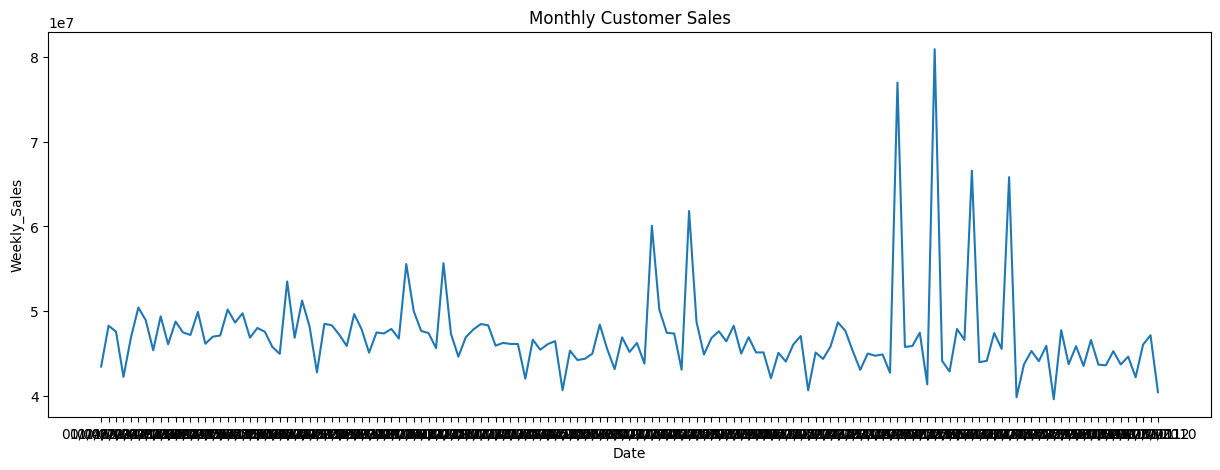

In [256]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'])
plt.xlabel("Date")
plt.ylabel("Weekly_Sales")
plt.title("Monthly Customer Sales")
plt.show()

call the difference on the sales column to make the sales data stationary

In [257]:
monthly_sales['Sales_diff']= monthly_sales['Weekly_Sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10) 

,Date,Weekly_Sales,Sales_diff
1,01/06/2012,48281649.72,4822658.53
2,01/07/2011,47578519.50,-703130.22
3,01/10/2010,42239875.87,-5338643.63
4,02/03/2012,46861034.97,4621159.10
5,02/04/2010,50423831.26,3562796.29
6,02/07/2010,48917484.50,-1506346.76
7,02/09/2011,45376623.27,-3540861.23
8,02/12/2011,49390556.49,4013933.22
9,03/02/2012,46085608.09,-3304948.40
10,03/06/2011,48771994.18,2686386.09


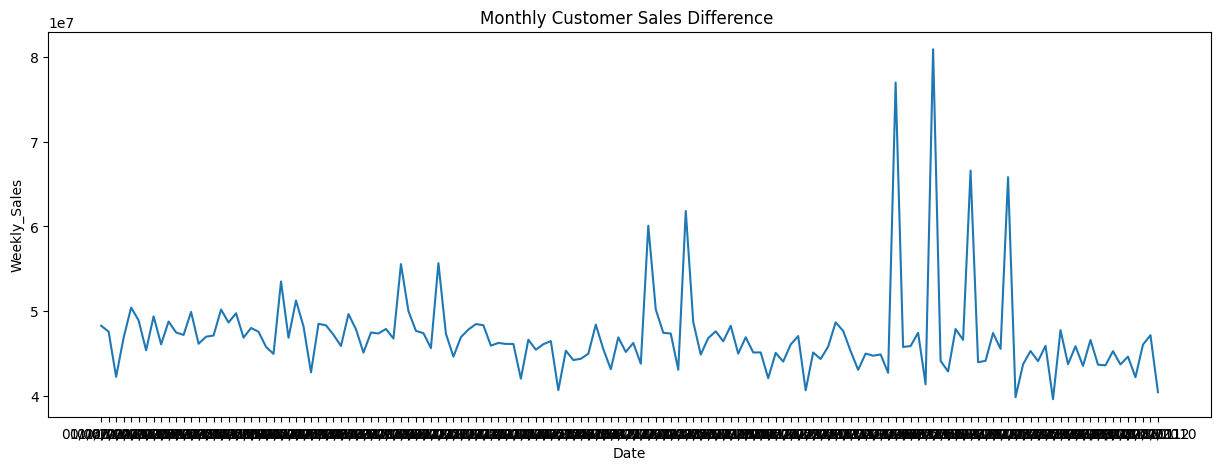

In [258]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'])
plt.xlabel("Date")
plt.ylabel("Weekly_Sales")
plt.title("Monthly Customer Sales Difference ")
plt.show()

Dropping off sales and date

In [259]:
supervised_data = monthly_sales.drop(['Date','Weekly_Sales'], axis=1)

Preparing the supervised data

In [260]:
for i in range(1,13):
    col_name = 'month_' +str(i)
    supervised_data[col_name] = supervised_data['Sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop= True)
supervised_data.head(10)    

,Sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23,-1506346.76,3562796.29,4621159.10,-5338643.63,-703130.22,4822658.53
1,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23,-1506346.76,3562796.29,4621159.10,-5338643.63,-703130.22
2,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23,-1506346.76,3562796.29,4621159.10,-5338643.63
3,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23,-1506346.76,3562796.29,4621159.10
4,3064345.19,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23,-1506346.76,3562796.29
5,-1532998.82,3064345.19,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23,-1506346.76
6,1095196.20,-1532998.82,3064345.19,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22,-3540861.23
7,-2879270.20,1095196.20,-1532998.82,3064345.19,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40,4013933.22
8,1143996.67,-2879270.20,1095196.20,-1532998.82,3064345.19,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09,-3304948.40
9,-448827.66,1143996.67,-2879270.20,1095196.20,-1532998.82,3064345.19,143594.19,827492.62,-3755916.76,2714770.27,-291641.95,-1286094.62,2686386.09


Split data into training and test data

In [261]:
train_data = supervised_data[:-12]
test_data= supervised_data[:-12]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (118, 13)
Test Data Shape:  (118, 13)


In [262]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


In [263]:
x_train,y_train = train_data[:,1:],train_data[:,0:1]
x_test,y_test= test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ",x_train.shape )
print("Y_train Shape: ",y_train.shape )
print("X_test Shape: ",x_test.shape )
print("Y_test Shape: ",y_test.shape )

X_train Shape:  (118, 12)
Y_train Shape:  (118,)
X_test Shape:  (118, 12)
Y_test Shape:  (118,)


Make prediction data frame to merge the predicted ale prices of all trained algorithm

In [264]:
sales_date = monthly_sales['Date'][-12:].reset_index(drop= True)
predict_df= pd.DataFrame(sales_date)

In [265]:
act_sales = monthly_sales['Weekly_Sales'][-13:].to_list()
print(act_sales)

[43734899.4, 45855821.05, 43530032.78, 46597112.12, 43683274.28, 43602830.95, 45272862.02, 43705126.71, 44630363.42, 42195830.81, 46042461.04, 47159639.43, 40432519.0]


Create the linear regression model and the predicted output

In [266]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [267]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)


In [268]:
result_list = []
for index in range(min(len(lr_pre_test_set), len(act_sales))):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)


In [269]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales["Weekly_Sales"][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales["Weekly_Sales"][-12:])
lr_R2 = r2_score(predict_df["Linear Prediction"], monthly_sales["Weekly_Sales"][-12:])
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MSE: ", lr_mae)
print("Linear Regression R2: ", lr_R2)

Linear Regression MSE:  3577026.595680374
Linear Regression MSE:  2304079.568723134
Linear Regression R2:  -1.075232822965007


Visualization of the prediction against the actual sales


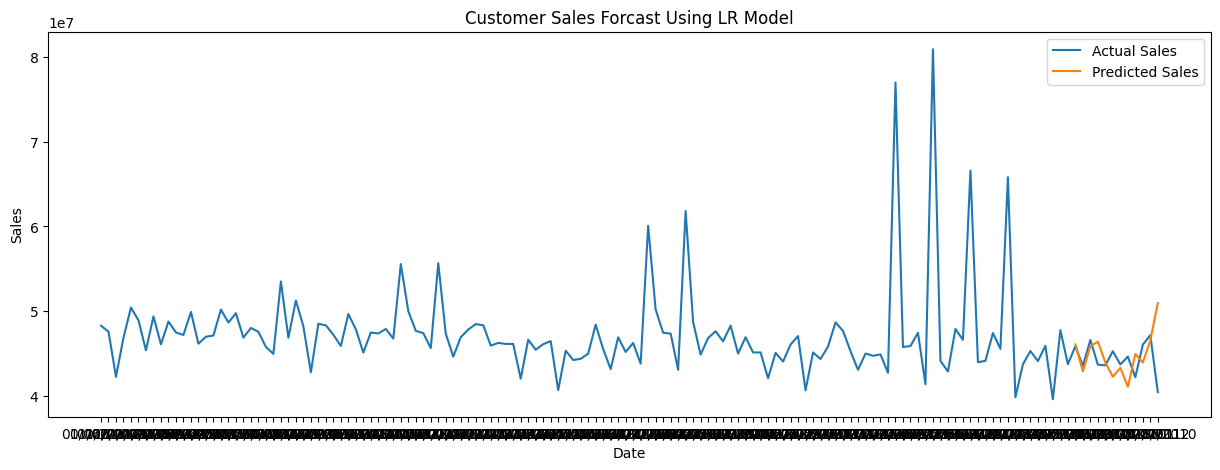

In [271]:
plt.figure(figsize=(15,5))
# actual sales
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'])
#predicted sales
plt.plot(predict_df['Date'],predict_df['Linear Prediction'])
plt.title("Customer Sales Forcast Using LR Model")
plt.xlabel('Date')
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()

